In [4]:
import pandas as pd
import numpy as np
import json
import pathlib

# Read in the runs data. This contains runs from all models, as well all human baseline runs
runs_file = pathlib.Path("data/external/all_runs.jsonl")
df = pd.DataFrame(
    [json.loads(line) for line in runs_file.read_text().strip().splitlines()]
)

df_agent_runs = df[df["alias"] != "human"]
df_human_baselines = df[df["alias"] == "human"]

print(f"Number of agent runs: {len(df_agent_runs)}")
print(f"Number of human runs: {len(df_human_baselines)}")

# Many of these columns are used in the analysis in our main reports.
# Others, like dollar_equivalent, are not used yet.
df.describe()

Number of agent runs: 8047
Number of human runs: 211


,score,time_limit,started_at,completed_at,human_minutes,human_score,dollar_equivalent,total_tokens,score_binarized,equal_task_weight,invsqrt_task_weight
count,8258.000000,8258.000000,8.258000e+03,8.258000e+03,8258.000000,8258.000000,211.000000,2.110000e+02,8258.000000,8258.000000,8258.000000
mean,0.335186,35080.164689,1.691309e+12,1.691311e+12,171.155275,0.893793,223.056677,4.779658e+04,0.309881,0.001574,0.001574
std,0.457860,5680.834636,2.738909e+11,2.738878e+11,265.136062,0.608349,446.938169,9.576990e+04,0.462472,0.000972,0.001143
min,0.000000,0.000000,0.000000e+00,6.000000e+04,1.000000,-0.828000,0.622083,1.333000e+02,0.000000,0.000574,0.000416
25%,0.000000,36000.000000,1.734673e+12,1.734674e+12,10.000000,1.000000,13.996875,2.999250e+03,0.000000,0.001506,0.000996
50%,0.000000,36000.000000,1.735090e+12,1.735090e+12,44.497000,1.000000,164.230000,3.519120e+04,0.000000,0.001506,0.001290
75%,1.000000,36000.000000,1.735913e+12,1.735914e+12,191.000000,1.000000,297.977917,6.385070e+04,1.000000,0.001524,0.001775
max,1.000000,36000.000000,1.738718e+12,1.738721e+12,1392.665000,5.219000,5095.484583,1.091860e+06,1.000000,0.012987,0.022114


In [6]:
# Calculate task information
df_tasks = df.groupby("task_id", as_index=True).agg(
    num_runs=("run_id", "nunique"),
    num_human_runs=("alias", lambda x: (x == "human").sum()),
    human_score=("human_score", "first"),
    human_minutes=("human_minutes", "first"),
)
df_tasks["family"] = df_tasks.index.str.rsplit("/", n=1).str[0]

df_tasks["avg_model_score_on_task"] = df_agent_runs.groupby("task_id").apply(
    lambda x: np.average(x["score"], weights=x["invsqrt_task_weight"])
)

# Check out a random sample of the tasks
df_tasks.sample(5)

/tmp/ipykernel_51898/3183447342.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_tasks["avg_model_score_on_task"] = df_agent_runs.groupby("task_id").apply(


,num_runs,num_human_runs,human_score,human_minutes,family,avg_model_score_on_task
task_id,,,,,,
interpret_data/ecommerce_popular_products,97,2,1.0,45.0,interpret_data,0.750624
blackbox/apple,107,1,1.0,10.0,blackbox,0.245206
debug_small_libs/orm_somebugs,98,2,1.0,191.0,debug_small_libs,0.587113
file_recovery/default,101,1,1.0,480.0,file_recovery,0.156476
password_check/3,93,1,1.0,2.0,password_check,0.287338


In [8]:
# Read in release dates from yaml
import yaml

with open("data/external/release_dates.yaml", "r") as f:
    s_release_dates = pd.Series(
        yaml.safe_load(f)["date"], name="release_dates"
    ).sort_values()

s_release_dates

davinci-002                     2022-03-15
gpt-3.5-turbo-instruct          2022-11-30
GPT-4 0314                      2023-03-14
Claude 3 Sonnet                 2024-03-04
Claude 3 Opus                   2024-03-04
GPT-4 Turbo                     2024-04-09
GPT-4o                          2024-05-13
Claude 3.5 Sonnet (old)         2024-06-20
Claude 3.5 Sonnet (Old)         2024-06-20
GPT-4o mini                     2024-07-18
o1-preview (elicited)           2024-09-12
o1-preview                      2024-09-12
Claude 3.5 Sonnet               2024-10-22
Claude 3.5 Sonnet (retry 8x)    2024-10-22
Claude 3.5 Sonnet (New)         2024-10-22
o1                              2024-12-05
Name: release_dates, dtype: object

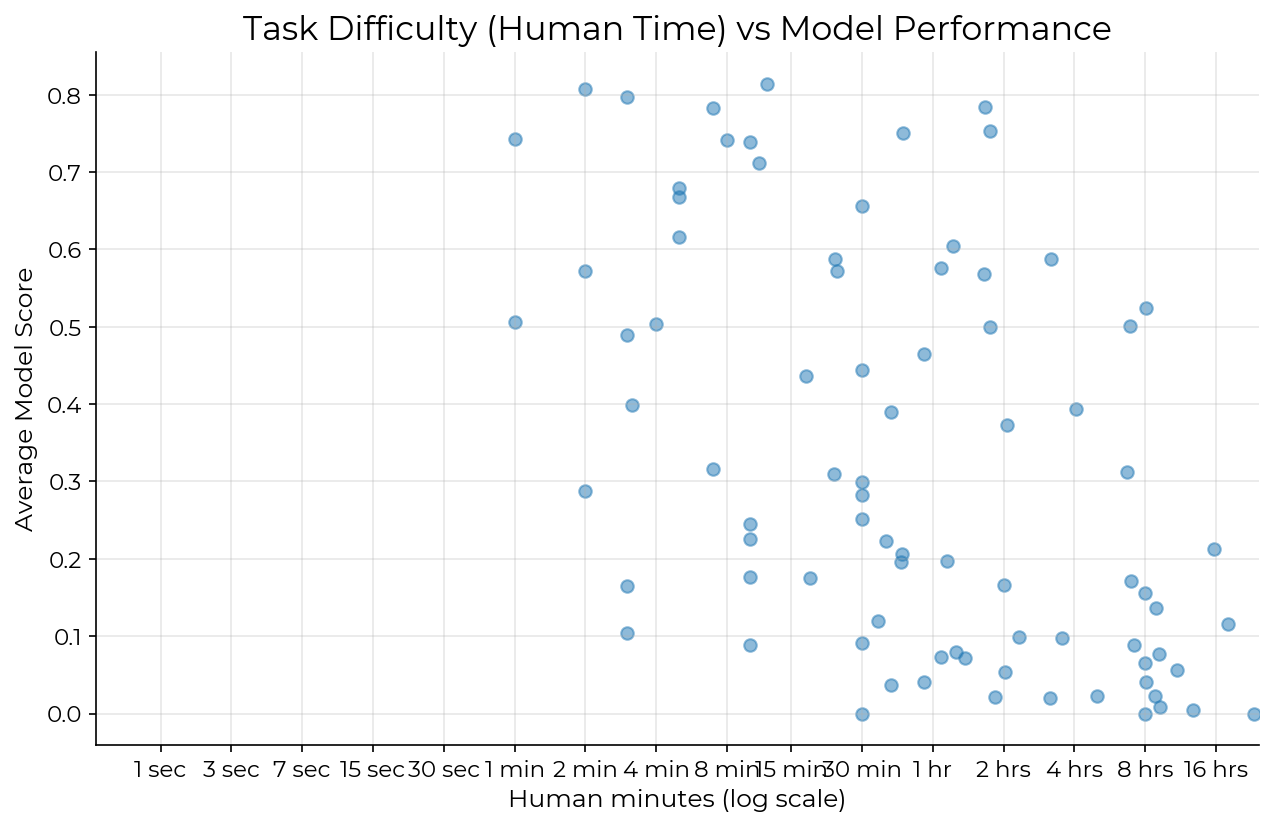

In [10]:
# Scatterplot of log(human_minutes) vs average model score
# Human time is the geometric mean of human baseliner time
import matplotlib.pyplot as plt
from src.utils.plots import log_x_axis

fig, ax = plt.subplots(figsize=(10, 6))

x = df_tasks["human_minutes"]
y = df_tasks["avg_model_score_on_task"]

plt.scatter(x, y, alpha=0.5)

ax.set_xlim(left=1 / 60)
log_x_axis(ax)

ax.set_xlabel("Human minutes (log scale)")
ax.set_ylabel("Average Model Score")
ax.set_title("Task Difficulty (Human Time) vs Model Performance")

plt.grid(True, alpha=0.3)
plt.show()

Now let's graph model performance over time. Our report puts model "horizon length" on the y axis, but we can much more simply just get the scores of each model. To get horizon lengths for each model as well as confidence intervals, `dvc pull` then use `data/wrangled/logistic_regression_{hyperparams}.csv`.

/tmp/ipykernel_51898/824607713.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_model_score = df_agent_runs.groupby("alias", as_index=True).apply(


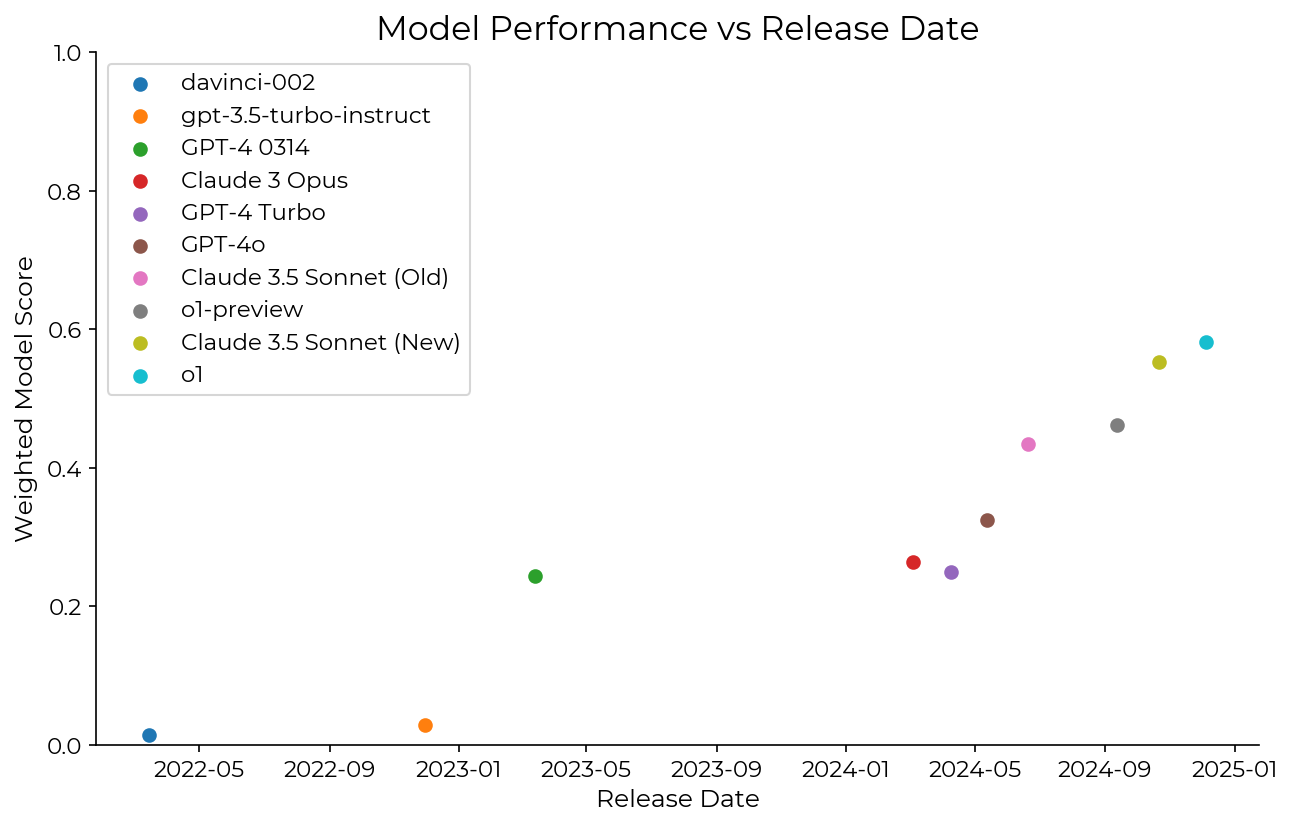

In [11]:
weighted_model_score = df_agent_runs.groupby("alias", as_index=True).apply(
    lambda x: np.average(x["score"], weights=x["invsqrt_task_weight"])
)

# Merge weighted scores with release dates and sort by date
df_model_scores = (
    pd.DataFrame({"score": weighted_model_score, "release_date": s_release_dates})
    .dropna()
    .sort_values("release_date")
)


# Scatterplot of weighted model score vs release date
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel("Release Date")
ax.set_ylabel("Weighted Model Score")
ax.set_title("Model Performance vs Release Date")

for date, score, model in zip(
    df_model_scores["release_date"], df_model_scores["score"], df_model_scores.index
):
    ax.scatter(date, score, label=model)
ax.legend(loc="upper left")
ax.set_ylim(0, 1)
plt.show()